In [1]:

import os,sys,glob
# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import Functions.globalFunctions.ExtracellularField as EcF
from matplotlib import cm
from typing import Literal
from scipy import integrate
import ipympl

#%matplotlib widget
recollect = False
fill_missing_xyzpositions = False
consider_fill = True


d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


In [2]:
#Functions
def selection_generator(df: pd.DataFrame,unique_values_columns: dict,verbose: bool = False,**kwargs) -> np.ndarray:
    idx = np.ones(len(df)).astype(bool)
    for key,val in kwargs.items():
        if verbose:
            print(f"{key}: {val} in unique_values_columns: {val in unique_values_columns[key]}")
        idx = idx & (df[key]==val)
    return idx

def VTA2D(rR,zZ,Data,*,grid_order:Literal['xy','ij'],cntrs = None,intensity:list,close_plot=True,cntr_order:Literal['rz','zr']=None) -> float:
    vta = []
    if cntrs is None:
        cntrs = plt.contour(zZ,rR,Data,intensity) #cntr_zr
        cntr_order = 'zr'
        if close_plot:
            plt.close(plt.gcf())
    else:
        if cntr_order is None:
            raise ValueError('provide cntr_order when cntr provided')

    for cntr in cntrs.collections:
        r = np.array([])
        z = np.array([])
        for path in cntr.get_paths():
            # if single contour consist of various pieces (eg start inside domain moves outside back inside => two different pieces)
            # then concatenate together
            if cntr_order=='rz':
                r = np.concatenate((r,path.vertices[:,0]))
                z = np.concatenate((z,path.vertices[:,1]))
            else:
                r = np.concatenate((r,path.vertices[:,1]))
                z = np.concatenate((z,path.vertices[:,0]))
        if len(z)==0:
            vta.append(np.nan)
        else:
            if (np.min(z)!=z[0]) and not grid_order=='ij':
                r = np.flip(r)
                z = np.flip(z)
            if (np.min(z)!=z[0]):
                r = np.roll(r,-z.argmin())
                z = np.roll(z,-z.argmin())
            #print('z:',z)
            #print('r:',r)
            if z[0]>min(zZ.ravel()):
                # fill the gap: if starts at certain z>z_min => contour is bigger than r_space => include cylinder from x_min -> z with r = r_max (still underestim but less: lower bound)
                z = np.append(min(zZ.ravel()),z)
                r = np.append(max(rR.ravel()),r)
            #print(r,z)
            # TODO process points twice same z -> simpson integrate returns nan
            # split probably not necessary because when change direction causes minus sign in integral( if z[i+1]<z[i] => dz <0 )
            # split: z should be monotonically increasing
            # sdz = np.sign(np.diff(z))
            # idx = (np.roll(sdz,1)!=sdz)
            # idx[0] = 0; idx = np.append(idx,0) # fix first always false + make same length as z
            # idx = np.where(idx)[0]
            # z = np.insert(z,idx,z[idx])
            # r = np.insert(r,idx,r[idx])
            # print(idx,np.where(idx)[0],z[idx])
            # print('\n after insert\n')
            # print('z\n',z)
            # print('r\n',r)
            # idx_split = np.where(z==np.roll(z,1))[0]
            # zsplit = np.split(z,idx_split)
            # rsplit = np.split(r,idx_split)
            # print('\nsplit_indx\n', idx_split)
            # print('zsplit \n',zsplit)
            # print('rsplit \n',rsplit)
            vta.append(np.abs(np.pi*integrate.trapezoid(r**2,z)))

    return vta


In [3]:
#Load data
filepath = './Results/SDC/SDC_CA1PCcACsig5_invivoUgent'
savename = os.path.join(filepath,'all_data.csv')

# list parameters of interest
positional_input = ['x','y','z','phi','theta','psi']
cell_init_options = ['phi_0','theta_0','psi_0']
settings_options = ['seed','celsius','dt']
opsin_options = ['Gmax','distribution','opsinmech','distribution_method','opsinlocations']
field_options = ['field','dc','nPulse','prf']
result = ['amp','dur']
all_columns = result+field_options+opsin_options+cell_init_options+positional_input+settings_options

# opsinlocations to single word
opsinLocation_map = {'1000':'soma','0100':'axon','0010':'apic','0001':'dend','0011':'alldend','1111':'allsec'}
if recollect:
    # list all data and input file locations
    alldata_files = [x for x in glob.glob(os.path.join(filepath,'**/data.json'),recursive=True) if not 'ToConcat' in x]
    allinput_files = [x for x in glob.glob(os.path.join(filepath,'**/input.json'),recursive=True) if not 'ToConcat' in x]
    dir_list = [x for x in glob.glob(os.path.join(filepath,'*')) if os.path.isdir(x) and not 'ToConcat' in x]
    print(f"result files: {len(alldata_files)}, input files: {len(allinput_files)}, directories: {len(dir_list)}")

    # init master_df: dataframe where all results will be stored
    master_df = pd.DataFrame(columns=all_columns)

    for data_path,input_path in zip(alldata_files,allinput_files):
        #print(data_path,input_path,)
        #Load data and input file
        with open(data_path,'r') as f:
            mydata = json.load(f)
        with open(input_path,'r') as f:
            myinput = json.load(f)

        # store global input info
        cell_init_dict = {key: myinput['info']['settings']['cellsopt']['init_options'][key.rsplit('_',1)[0]] for key in cell_init_options}
        settings_dict = {key: myinput['info']['settings'][key] for key in settings_options}
        opsin_dict = {**{opsin_options[0]:myinput['info']['settings']['cellsopt']['opsin_options'][opsin_options[0]+'_total']},**{key: myinput['info']['settings']['cellsopt']['opsin_options'][key] for key in opsin_options[1:]}}
        field_dict = {field_options[0]:myinput['info']['settings']['stimopt']['Ostimparams']['filepath'].rsplit('/',1)[-1].rsplit('.txt',1)[0],
        field_options[1]:myinput['info']['settings']['analysesopt']['SDOptogenx']['options'][field_options[1]+'_sdc'],
        field_options[2]:myinput['info']['settings']['analysesopt']['SDOptogenx']['r_p'.join(field_options[2].split('P'))+'OI'],
        field_options[3]:myinput['info']['settings']['stimopt']['Ostimparams']['options'][field_options[3]]}

        opsin_dict['opsinlocations'] = opsinLocation_map[''.join([str(int(any([loc in oloc for oloc in opsin_dict['opsinlocations']]))) for loc in list(opsinLocation_map.values())[:4]])]

        info_dict = {**field_dict,**opsin_dict,**cell_init_dict,**settings_dict}

        # store simulation specific info and add to dataframe
        durs = myinput["info"]['settings']['analysesopt']['SDOptogenx']["durs"]
        for k in mydata.keys():
            cellPos_dict = {**{key:myinput[k]['xT'][i]for i,key in enumerate(positional_input[0:3])},**{key:myinput[k][key]for key in positional_input[3:]}}
            for amp,dur in zip(mydata[k]["SDcurve"]["Optogenx"],durs):
                result_dict = {result[0]:amp, result[1]:dur}
                intm = pd.DataFrame({**result_dict,**cellPos_dict,**info_dict},index=[0],columns=all_columns)
                master_df = pd.concat([master_df,pd.DataFrame({**result_dict,**cellPos_dict,**info_dict},index=[0],columns=all_columns)])

    master_df = master_df.reset_index(drop=True)
    master_df.to_csv(savename)
else:
    master_df = pd.read_csv(savename,index_col=0)

unique_values_columns = {key: master_df[key].unique() for key in all_columns}
master_df.head()


,amp,dur,field,dc,nPulse,prf,Gmax,distribution,opsinmech,distribution_method,...,psi_0,x,y,z,phi,theta,psi,seed,celsius,dt
0,69062.5000,0.01,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025
1,1856.0547,0.10,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025
2,237.8070,1.00,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025
3,94.0081,10.00,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025
4,72.1953,100.00,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025


In [4]:
if consider_fill:
    if fill_missing_xyzpositions:
        # append nan missing positions
        setting_keys = ['dur',*cell_init_options,*settings_options,*opsin_options,*field_options]
        master_df['settings_str'] = master_df.apply(lambda x: '_'.join([str(x[key]) for key in setting_keys]),axis=1)

        print(len(master_df))
        xX, yY, zZ = np.meshgrid(unique_values_columns['x'],unique_values_columns['y'],unique_values_columns['z'])
        target = np.array((xX.ravel(),yY.ravel(),zZ.ravel())).T
        print(target.shape)
        usettings_str = list(master_df['settings_str'].unique())
        print(len(usettings_str))
        master_df.head()
        for uset in usettings_str:
            intm_df = master_df[master_df['settings_str']==uset]

            source = np.array((intm_df['x'],intm_df['y'],intm_df['z'])).T
            #source[:,None]: Nx3 -> Nx1x3 (same as source[:,None,:])
            # target==source[:,None]: Mx3 == Nx1x3 -> 1xMx3 == Nx1x3 -> NxMx3
            # np.all(target==source[:, None], axis=2): NxMx3 -> NxM
            # *.any(axis=0): NxM -> M if column (Mi) has no true -> any false -> ~any => true = missing row
            missing = target[~np.all(target==source[:, None], axis=2).any(axis=0)]
            if len(missing)>0:
                for i,missing_row in enumerate(missing):
                    a = intm_df.iloc[0:1].copy()
                    a['x'], a['y'], a['z'] = missing_row
                    a['amp'] = np.nan
                    insert_position = intm_df.index[-1]+(i+1)/target.shape[0]
                    master_df.loc[insert_position] = a.to_numpy()[0]
        intm_df.head()
        print(len(master_df))
        master_df.tail()
        master_df = master_df.sort_index().reset_index(drop=True)
        savename = savename.rsplit('.csv')[0]+'_filled.csv'
        master_df.to_csv(savename)
    else:
        savename = savename.rsplit('.csv')[0]+'_filled.csv'
        master_df = pd.read_csv(savename,index_col=0)

unique_values_columns = {key: master_df[key].unique() for key in all_columns}
master_df.head()

,amp,dur,field,dc,nPulse,prf,Gmax,distribution,opsinmech,distribution_method,...,x,y,z,phi,theta,psi,seed,celsius,dt,settings_str
0,69062.5000,0.01,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025,0.01_0_-1.5707963267948966_0_1638360000.0_34_0...
1,1856.0547,0.10,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025,0.1_0_-1.5707963267948966_0_1638360000.0_34_0....
2,237.8070,1.00,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025,1.0_0_-1.5707963267948966_0_1638360000.0_34_0....
3,94.0081,10.00,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025,10.0_0_-1.5707963267948966_0_1638360000.0_34_0...
4,72.1953,100.00,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...


In [5]:
#test selector
myselection = {key:unique_values_columns[key][0] for key in [*cell_init_options,*settings_options,*opsin_options,*field_options]}
myselection['dur'] = 100
intm_df = master_df[selection_generator(master_df,unique_values_columns,verbose=False,**myselection)].reset_index(drop=True)
intm_df.head(len(intm_df))


,amp,dur,field,dc,nPulse,prf,Gmax,distribution,opsinmech,distribution_method,...,x,y,z,phi,theta,psi,seed,celsius,dt,settings_str
0,7.219530e+01,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,0.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
1,1.678781e+02,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,500.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
2,1.630354e+03,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,1000.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
3,8.034311e+03,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,1500.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
4,2.758548e+04,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,0.0,2000.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.928611e+05,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,1800.0,2500.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
96,5.623102e+05,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,1800.0,3000.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
97,1.146060e+06,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,1800.0,3500.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...
98,2.450874e+06,100.0,Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10,1.0,1,0.1,2.160768,distribution = lambda x: 10.0,chr2h134r,3d,...,0.0,1800.0,4000.0,0,-1.570796,0,1.638360e+09,34,0.025,100.0_0_-1.5707963267948966_0_1638360000.0_34_...


{'phi_0': 0, 'theta_0': -1.5707963267948966, 'psi_0': 0, 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'Gmax': 2.1607680884889966, 'distribution': 'distribution = lambda x: 10.0', 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'dc': 1.0, 'nPulse': 1, 'prf': 0.1}



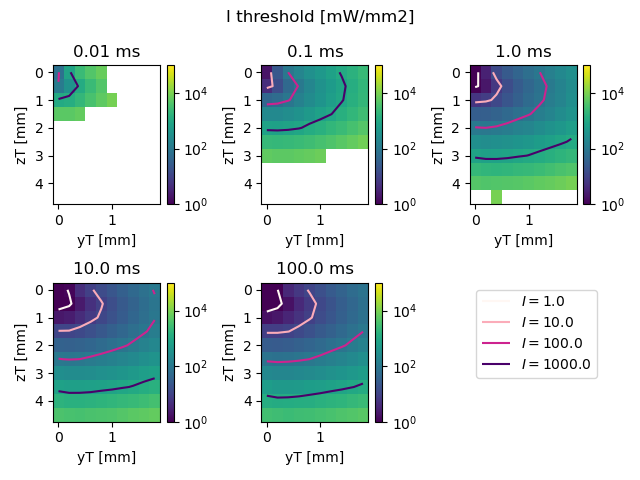

In [6]:
myselection = {key:unique_values_columns[key][0] for key in [*cell_init_options,*settings_options,*opsin_options,*field_options]}
single_config_df = master_df[selection_generator(master_df,unique_values_columns,verbose=False,**myselection)].reset_index(drop=True)
print(myselection)

Imin = np.min(single_config_df['amp'])
Imax = 1e5#np.max(single_config_df['amp'])
levels = np.logspace(0,3,4)
norm_log = cm.colors.LogNorm(vmax=Imax, vmin=1)
norm_log_cntr = cm.colors.LogNorm(vmax=levels[-1], vmin=levels[0])


udurs = list(single_config_df['dur'].unique())
fig,axs = plt.subplots(int(len(udurs)/3+0.5),3,tight_layout = True)

for dur,ax in zip(udurs,axs.ravel()):
    intm_df = single_config_df[single_config_df['dur']==dur]
    data_toplot = EcF.prepareDataforInterp(np.array((intm_df['y'],intm_df['z'],intm_df['amp'])).T/1000,'ninterp')
    yY, zZ = np.meshgrid(np.linspace(data_toplot[0].min(),data_toplot[0].max(),len(np.unique(data_toplot[0])),endpoint=True),np.linspace(data_toplot[1].min(),data_toplot[1].max(),len(np.unique(data_toplot[0])),endpoint=True))

    im,cntr,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm_log,invert_yaxis=True,contour_kwargs={'norm':norm_log_cntr,'cmap':'RdPu','levels':levels})
    ax.set_xlabel('yT [mm]')
    ax.set_ylabel('zT [mm]')
    ax.set_title(f'{dur} ms')
fig.suptitle('I threshold [mW/mm2]')
h, l = cntr.legend_elements("I")
axs[-1,-1].legend(h, l,ncol=1,loc='upper center')
axs[-1,-1].axis('off')
print()

2.1607680884889966
{'phi_0': 0, 'theta_0': -1.5707963267948966, 'psi_0': 0, 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'dc': 1.0, 'nPulse': 1, 'prf': 0.1, 'Gmax': 2.1607680884889966}

6.832948655033484
{'phi_0': 0, 'theta_0': -1.5707963267948966, 'psi_0': 0, 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'dc': 1.0, 'nPulse': 1, 'prf': 0.1, 'Gmax': 6.832948655033484}

21.607680884889987
{'phi_0': 0, 'theta_0': -1.5707963267948966, 'psi_0': 0, 'seed': 1638360000.0, 'celsius': 34, 'dt': 0.025, 'opsinmech': 'chr2h134r', 'distribution_method': '3d', 'opsinlocations': 'allsec', 'field': 'Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10', 'dc': 1.0, 'nPulse': 1, 'prf': 0.1, 'Gmax': 21.607680884889987}

68.32948655033485


C:\Users\rschoete\AppData\Local\Temp\ipykernel_8624\520019559.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs = plt.subplots(int(len(udurs)/3+0.67),3,tight_layout = True,figsize=np.array([10,8])*0.9)


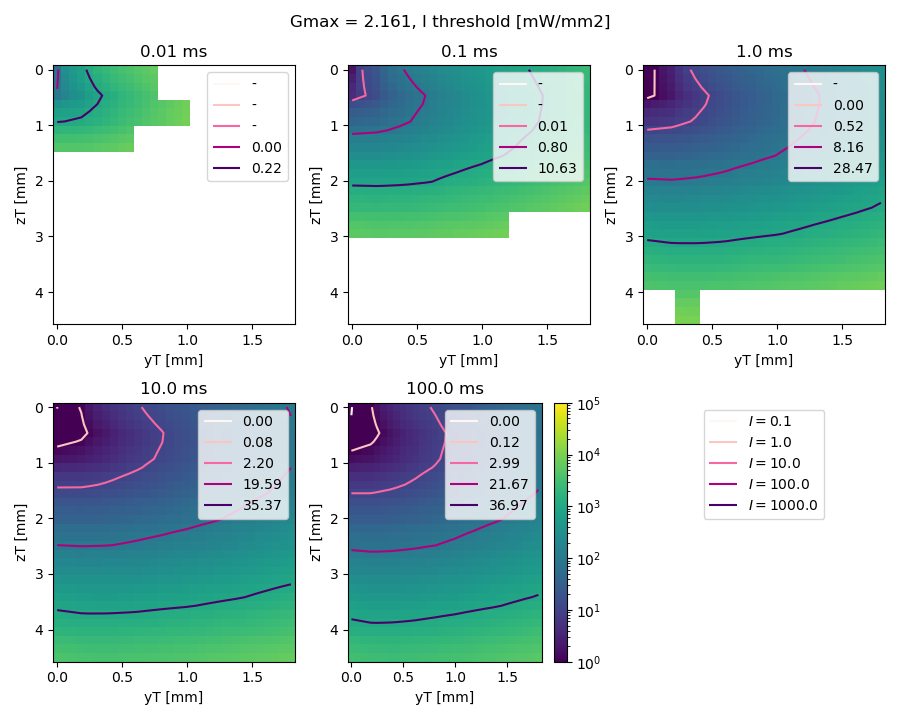

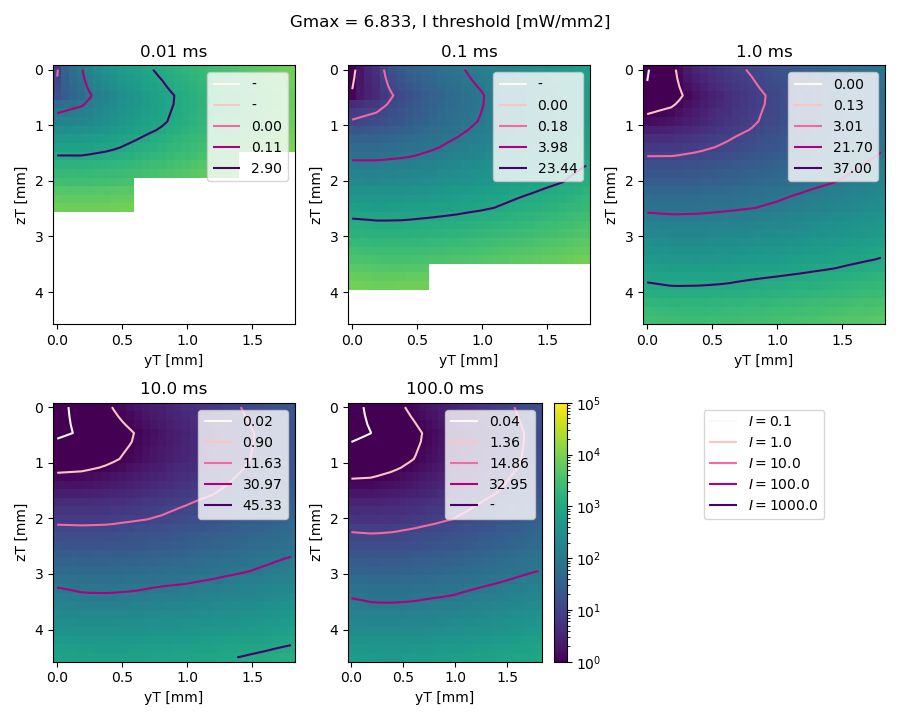

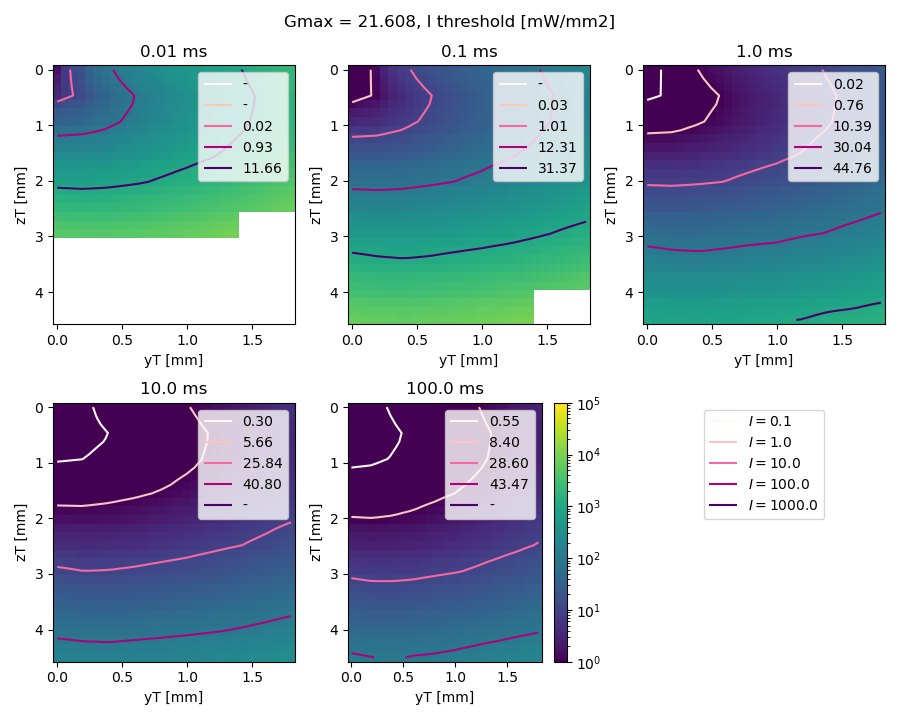

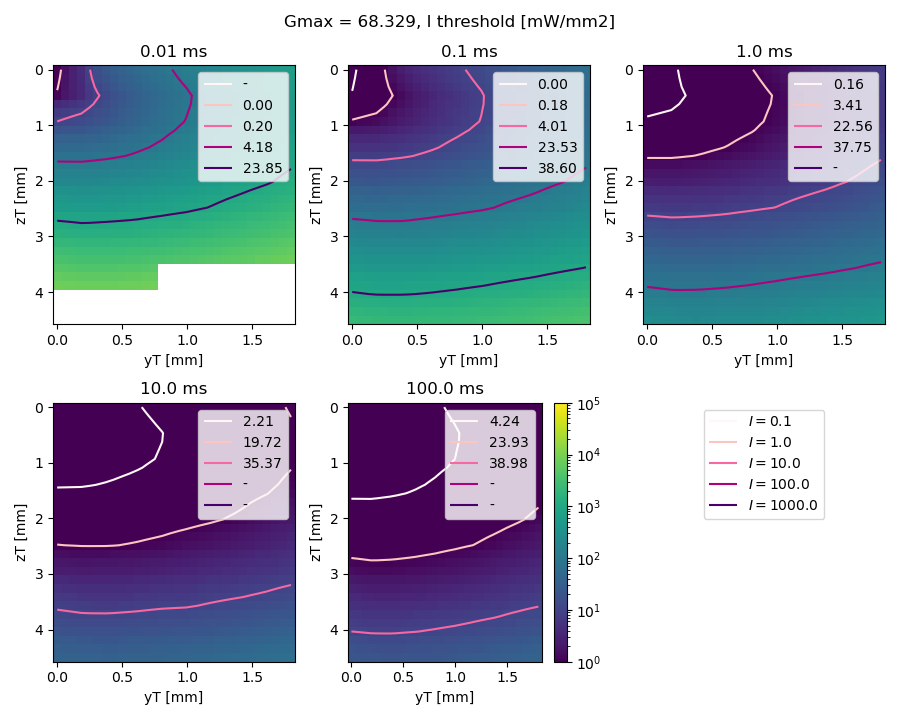

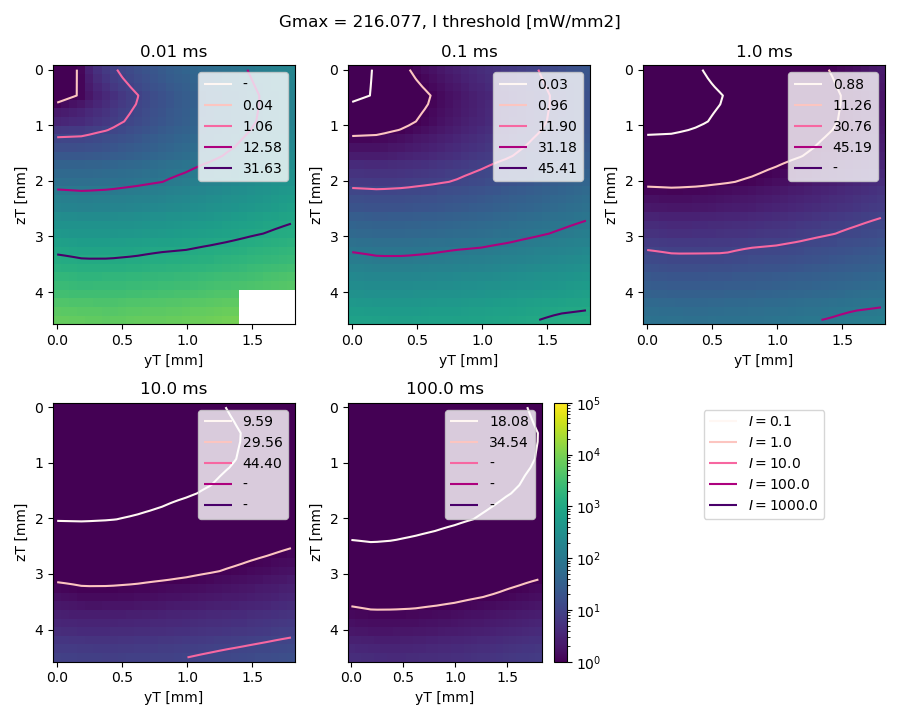

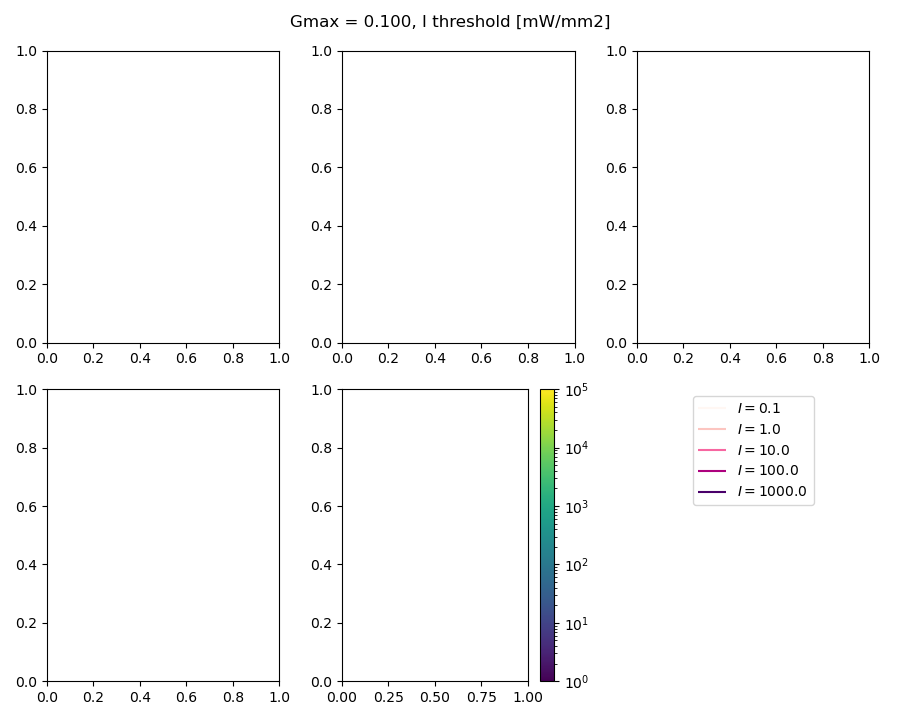

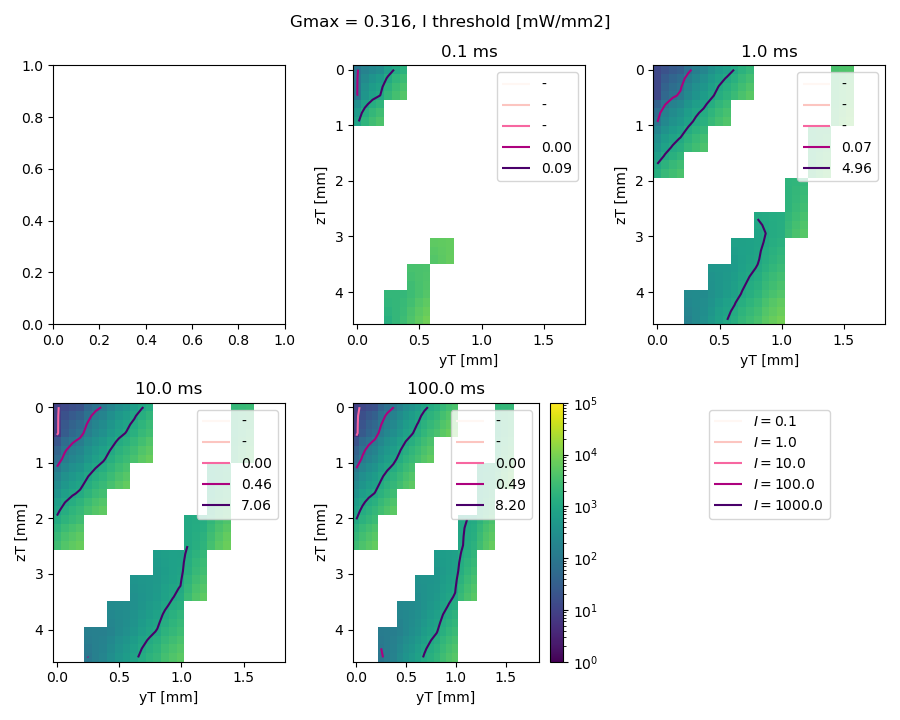

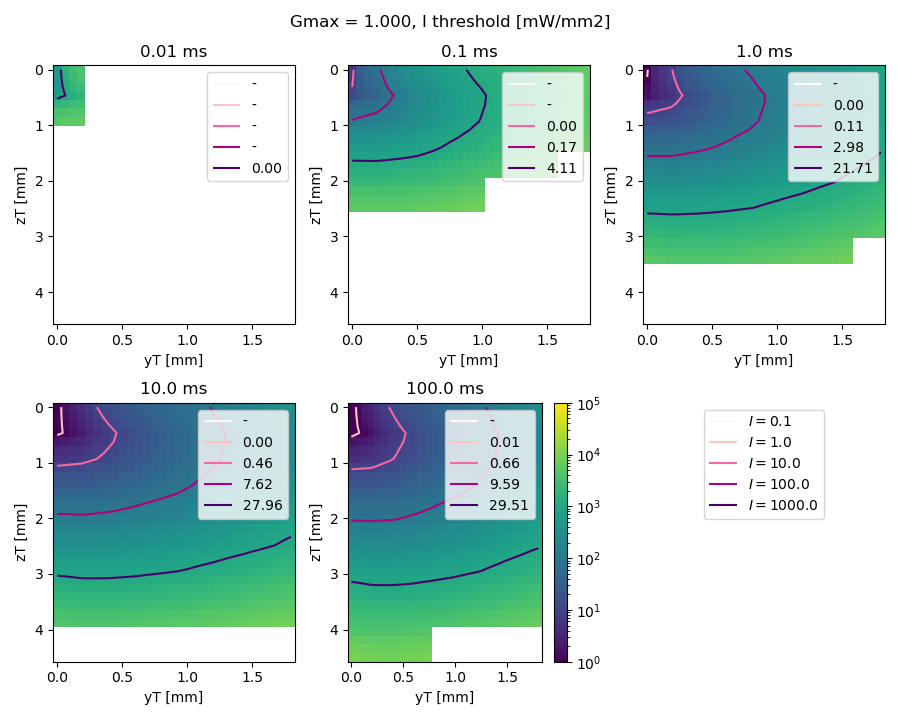

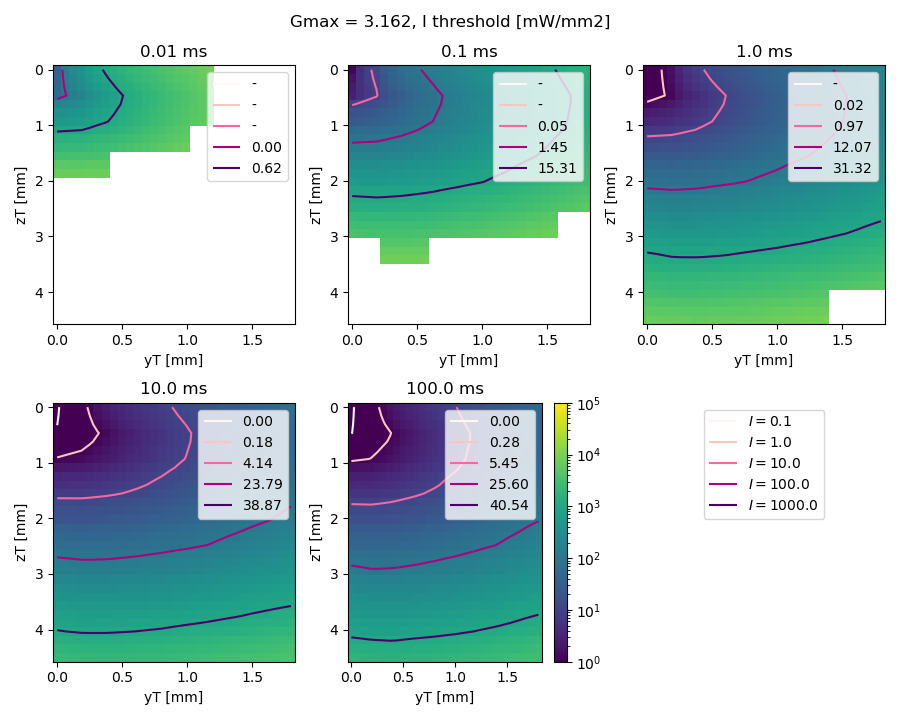

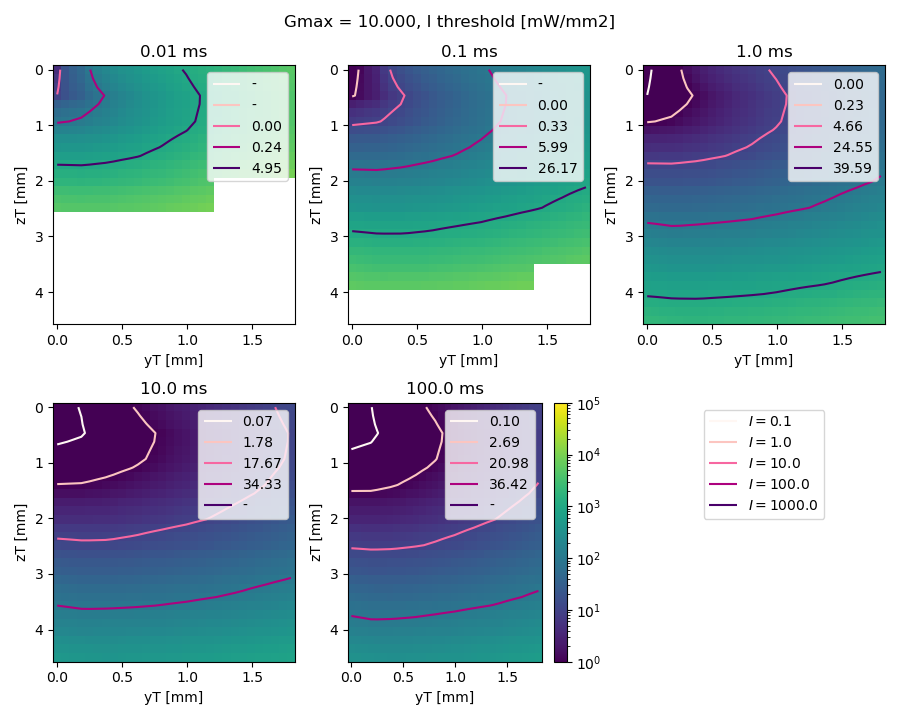

In [9]:
myselection_noGmax = {key:unique_values_columns[key][0] for key in [*cell_init_options,*settings_options,*opsin_options,*field_options] if not key in ['Gmax','distribution']}
intm_df = master_df[selection_generator(master_df,unique_values_columns,verbose=False,**myselection_noGmax)]
gmaxs = list(intm_df['Gmax'].unique())
for gmax in gmaxs:
    print(gmax)
    myselection = {**myselection_noGmax, 'Gmax': gmax}
    single_config_df = master_df[selection_generator(master_df,unique_values_columns,verbose=False,**myselection)].reset_index(drop=True)
    print(myselection)

    Imin = np.min(single_config_df['amp'])
    Imax = 1e5#np.max(single_config_df['amp'])
    levels = np.logspace(-1,3,5)
    norm_log = cm.colors.LogNorm(vmax=Imax, vmin=1)
    norm_log_cntr = cm.colors.LogNorm(vmax=levels[-1], vmin=levels[0])


    udurs = list(single_config_df['dur'].unique())
    fig,axs = plt.subplots(int(len(udurs)/3+0.67),3,tight_layout = True,figsize=np.array([10,8])*0.9)

    for dur,ax in zip(udurs,axs.ravel()):
        intm_df = single_config_df[single_config_df['dur']==dur]
        if not np.all(np.isnan(intm_df['amp'])):
            data_toplot = EcF.prepareDataforInterp(np.array((intm_df['y'],intm_df['z'],intm_df['amp'])).T/1000,'ninterp')
            #yY, zZ = np.meshgrid(np.linspace(data_toplot[0].min(),data_toplot[0].max(),len(np.unique(data_toplot[0])),endpoint=True),np.linspace(data_toplot[1].min(),data_toplot[1].max(),len(np.unique(data_toplot[0])),endpoint=True))
            yY, zZ = np.meshgrid(np.linspace(data_toplot[0].min(),data_toplot[0].max(),30,endpoint=True),np.linspace(data_toplot[1].min(),data_toplot[1].max(),30,endpoint=True))
            im,cntr,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm_log,invert_yaxis=True,contour_kwargs={'norm':norm_log_cntr,'cmap':'RdPu','levels':levels})
            ax.set_xlabel('yT [mm]')
            ax.set_ylabel('zT [mm]')
            ax.set_title(f'{dur} ms')
            cb.remove()
            h, l = cntr.legend_elements("I")
            
            #print('\nvta')
            #print(EcF.checkGridOrder(yY.ravel(),zZ.ravel()))
            vta = VTA2D(yY,zZ,im.get_array().reshape(yY.shape),grid_order=EcF.checkGridOrder(yY.ravel(),zZ.ravel()),cntrs=cntr,cntr_order='rz',intensity = levels)
            ax.legend(h, [f'{x:0.2f}' if ~np.isnan(x) else '-' for x in vta],ncol=1,loc='upper right')
            #print('\nvta2')
            #print(EcF.checkGridOrder(yY.T.ravel(),zZ.T.ravel()))
            #vta2 = VTA2D(yY.T,zZ.T,im.get_array().reshape(yY.shape).T,grid_order=EcF.checkGridOrder(yY.T.ravel(),zZ.T.ravel()),intensity = levels,close_plot=False)
            #if np.any((np.array(vta)-np.array(vta2))>1e-10):
            #    print(np.array(vta)-np.array(vta2))

    fig.suptitle(f'Gmax = {gmax:0.3f}, I threshold [mW/mm2]')
    h, l = cntr.legend_elements("I")
    axs[-1,-1].legend(h, l,ncol=1,loc='upper center')
    axs[-1,-1].axis('off')
    cb = fig.colorbar(im,ax=axs[-1,-2])
    print()

In [8]:
usettings_str = list(master_df['settings_str'].unique())
print(len(usettings_str))
master_df.head()
for uset in usettings_str[:1]:
    intm_df = master_df[master_df['settings_str']==uset]
    X = np.array(intm_df['x'])/1000; Y = np.array(intm_df['y'])/1000; Z = np.array(intm_df['z'])/1000
    uX = np.unique(X); uY = np.unique(Y); uZ = np.unique(Z)
    data = np.array(intm_df['amp'])/1000

    order = EcF.checkGridOrder(Y,Z)
    print(order)
    if order == 'xy':
        n_row = len(uZ)
        n_col = len(uY)
        X = np.reshape(X,(n_row,n_col))
        Y = np.reshape(Y,(n_row,n_col))
        Z = np.reshape(Z,(n_row,n_col))
        data = np.reshape(data,(n_row,n_col))
    else:
        n_row = len(uY)
        n_col = len(uZ)
        X = np.reshape(X,(n_row,n_col))
        Y = np.reshape(Y,(n_row,n_col))
        Z = np.reshape(Z,(n_row,n_col))
        data = np.reshape(data,(n_row,n_col))

    vta = VTA2D(Y,Z,data,intensity=np.logspace(0,3,4))
    print(vta)

800
ij


TypeError: VTA2D() missing 1 required keyword-only argument: 'grid_order'

No such comm: aec0d8a2a0bf4f34869e751b64e3dfa0


No such comm: d4270c2b458f45b0b7bde3da36c37c6e
